# Experiment B — IMS Bearings: STFT + Autoencoder (Run-to-Failure)

## Goal
Build a time–frequency anomaly score using **STFT + Autoencoder reconstruction loss** on IMS bearings.
This experiment extends the "it depends" message: time-domain and frequency-domain can each be better
depending on failure mode and signal characteristics. STFT is used as a practical compromise because it
preserves both *when* and *where (in frequency)* changes occur.

## Dataset
IMS bearings (run-to-failure). Each file is a ~1-second snapshot. Folder layout:
`data/external/ims_bearings/{1st_test,2nd_test,3rd_test}/<timestamp_filename>`

## Output
- Per-snapshot anomaly score over time for each run
- Healthy-only training on early-life snapshots
- Operational thresholds (p99 / p99.5) + smoothing (rolling median/quantiles)


# 1. Import

In [1]:
from __future__ import annotations

import os
import re
import glob
from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal

# Deep learning (Experiment B core)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:
@dataclass(frozen=True)
class IMSConfig:
    data_root: Path
    fs_hz: int = 20480              # typical IMS sampling rate
    n_channels: int = 8             # your files show 8 columns
    use_channel: int = 0            # start with ch1 (0-based)
    window_size: int = 2048
    overlap: float = 0.5

    # STFT per window
    stft_nperseg: int = 256
    stft_noverlap: int = 192
    stft_nfft: int = 512

    # Training: first fraction of snapshots per run are treated as "healthy baseline"
    healthy_fraction_per_run: float = 0.2

    # Score aggregation (from window-level -> snapshot-level)
    snapshot_agg: str = "p95"       # mean | p95 | max

    # Smoothing for operational view
    smooth_window: int = 15         # rolling window in snapshots (tune)
    

cfg = IMSConfig(data_root=Path("../../../data/external/ims_bearings").resolve())
print(cfg)
print("Data root exists?", cfg.data_root.exists(), cfg.data_root)


IMSConfig(data_root=WindowsPath('C:/Users/M4005001/OneDrive - Saint-Gobain/Pessoal/Alura/Anomaly_Detection/unsupervised_industrial_anomaly_detection/data/external/ims_bearings'), fs_hz=20480, n_channels=8, use_channel=0, window_size=2048, overlap=0.5, stft_nperseg=256, stft_noverlap=192, stft_nfft=512, healthy_fraction_per_run=0.2, snapshot_agg='p95', smooth_window=15)
Data root exists? True C:\Users\M4005001\OneDrive - Saint-Gobain\Pessoal\Alura\Anomaly_Detection\unsupervised_industrial_anomaly_detection\data\external\ims_bearings


# 2. Data Index (Run-to-Failure Timeline)

We build a tidy index with:
- run_id: {1st_test, 2nd_test, 3rd_test}
- filepath
- timestamp parsed from filename
- per-run file ordering
- life_fraction: normalized position in the run [0,1]


In [3]:
def discover_ims_index(data_root: Path) -> pd.DataFrame:
    if not data_root.exists():
        raise FileNotFoundError(f"IMS root not found: {data_root}")

    # IMS data files usually look like: YYYY.MM.DD.HH.MM.SS (no extension or .txt)
    ts_pat = re.compile(r"^\d{4}\.\d{2}\.\d{2}\.\d{2}\.\d{2}\.\d{2}(\.txt)?$")

    rows = []
    for p in data_root.rglob("*"):
        if not p.is_file():
            continue
        if p.stat().st_size < 1000:
            continue

        # filter by filename pattern
        if not ts_pat.match(p.name):
            continue

        rel = p.relative_to(data_root)
        run_id = rel.parts[0] if len(rel.parts) > 0 else "unknown_run"

        m = re.search(r"(\d{4})\.(\d{2})\.(\d{2})\.(\d{2})\.(\d{2})\.(\d{2})", p.name)
        ts = None
        if m:
            ts = f"{m.group(1)}-{m.group(2)}-{m.group(3)} {m.group(4)}:{m.group(5)}:{m.group(6)}"

        rows.append(
            dict(run_id=run_id, filepath=str(p), filename=p.name, timestamp=ts)
        )

    if not rows:
        raise FileNotFoundError(
            f"No IMS timestamp-like files found under {data_root}. "
            "Expected names like YYYY.MM.DD.HH.MM.SS or YYYY.MM.DD.HH.MM.SS.txt"
        )

    df = pd.DataFrame(rows)
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    df = df.sort_values(["run_id", "timestamp", "filename"]).reset_index(drop=True)
    df["file_order"] = df.groupby("run_id").cumcount()

    # numeric sort_key (pandas-compatible)
    ts_ns = pd.to_datetime(df["timestamp"], errors="coerce").astype("int64")
    df["sort_key"] = np.where(df["timestamp"].notna(), ts_ns, df["file_order"].astype("int64"))

    df = df.sort_values(["run_id", "sort_key", "filename"]).reset_index(drop=True)

    df["life_fraction"] = (
        df.groupby("run_id").cumcount() / df.groupby("run_id")["filepath"].transform("count")
    )
    return df



In [4]:
index_df = discover_ims_index(cfg.data_root)
print(index_df.dtypes)
display(index_df.groupby("run_id").agg(n_files=("filepath","count")).sort_values("n_files", ascending=False))
index_df.head()



run_id                      str
filepath                    str
filename                    str
timestamp        datetime64[us]
file_order                int64
sort_key                  int64
life_fraction           float64
dtype: object


,n_files
run_id,
3rd_test,6324
1st_test,2156
2nd_test,984


,run_id,filepath,filename,timestamp,file_order,sort_key,life_fraction
0,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2003.10.22.12.06.24,2003-10-22 12:06:24,0,1066824384000000,0.000000
1,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2003.10.22.12.09.13,2003-10-22 12:09:13,1,1066824553000000,0.000464
2,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2003.10.22.12.14.13,2003-10-22 12:14:13,2,1066824853000000,0.000928
3,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2003.10.22.12.19.13,2003-10-22 12:19:13,3,1066825153000000,0.001391
4,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2003.10.22.12.24.13,2003-10-22 12:24:13,4,1066825453000000,0.001855


# 3. Snapshot Reader

Each IMS file is a 1-second snapshot with multiple channels (columns).
We start with a single channel baseline (ch1) to keep Experiment B focused.
 

Loaded: 2003.10.22.12.06.24
Shape: (20480, 8) dtype: float32


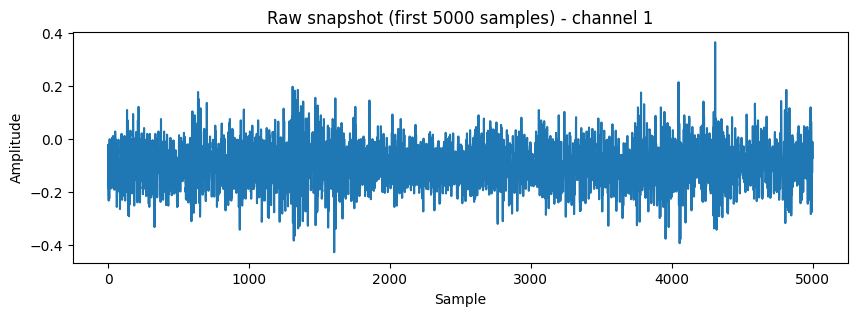

In [5]:
def read_ims_snapshot(filepath: str) -> np.ndarray:
    """
    Robust reader for IMS snapshot files. Skips non-numeric files defensively.
    """
    # quick signature check to avoid trying to parse PDFs, etc.
    with open(filepath, "rb") as f:
        head = f.read(8)
    if head.startswith(b"%PDF"):
        raise ValueError(f"File looks like a PDF, not IMS data: {filepath}")

    df = pd.read_csv(
        filepath,
        header=None,
        sep=r"\s+",
        engine="python",
        encoding="latin1",
        on_bad_lines="skip",
    )

    # Drop rows that became non-numeric (rare but possible)
    df = df.apply(pd.to_numeric, errors="coerce").dropna(how="any")

    x = df.values.astype(np.float32)
    if x.ndim != 2:
        raise ValueError(f"Unexpected shape: {x.shape} for {filepath}")
    return x


# Load one snapshot
sample_path = index_df.iloc[0]["filepath"]
x = read_ims_snapshot(sample_path)
print("Loaded:", Path(sample_path).name)
print("Shape:", x.shape, "dtype:", x.dtype)

plt.figure(figsize=(10, 3))
plt.plot(x[:5000, cfg.use_channel])
plt.title(f"Raw snapshot (first 5000 samples) - channel {cfg.use_channel+1}")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()


# 4. Windowing

Each 1-second snapshot is split into overlapping windows (2048 samples, 50% overlap).
The Autoencoder will operate on STFT patches computed for each window.


In [6]:
def window_1d(x: np.ndarray, window_size: int, overlap: float) -> np.ndarray:
    if x.ndim != 1:
        raise ValueError("x must be 1D")
    step = int(window_size * (1.0 - overlap))
    if step <= 0:
        raise ValueError("Invalid overlap/window_size (step <= 0)")

    n = len(x)
    if n < window_size:
        return np.empty((0, window_size), dtype=np.float32)

    starts = np.arange(0, n - window_size + 1, step, dtype=int)
    return np.stack([x[s:s+window_size] for s in starts], axis=0).astype(np.float32)

x_ch = x[:, cfg.use_channel]
W = window_1d(x_ch, cfg.window_size, cfg.overlap)
print("Windowed shape:", W.shape)  # (n_windows, window_size)


Windowed shape: (19, 2048)


# 5. STFT Representation (Time–Frequency)

For each window, compute STFT magnitude (log-scaled) to obtain a 2D patch:
(freq_bins, time_bins)

This preserves:
- *when* changes happen (time bins)
- *where* changes happen (frequency bins)


STFT patches shape: (19, 257, 29)


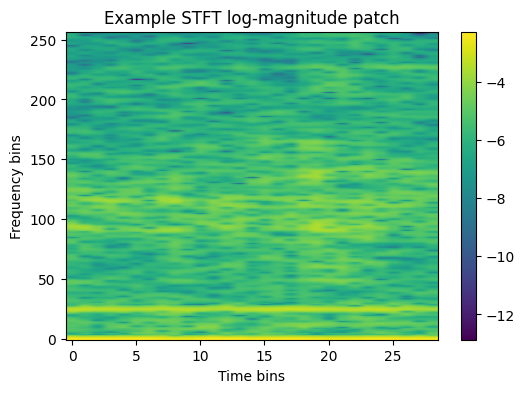

In [7]:
def stft_patch(
    w: np.ndarray,
    fs_hz: int,
    nperseg: int,
    noverlap: int,
    nfft: int,
    eps: float = 1e-8
) -> np.ndarray:
    # w: (window_size,)
    f, t, Zxx = signal.stft(
        w,
        fs=fs_hz,
        nperseg=nperseg,
        noverlap=noverlap,
        nfft=nfft,
        boundary=None,
        padded=False,
    )
    mag = np.abs(Zxx).astype(np.float32)
    logmag = np.log(mag + eps).astype(np.float32)
    return logmag  # shape: (freq_bins, time_bins)

# Build patches for one snapshot (all windows)
patches = np.stack(
    [
        stft_patch(w, cfg.fs_hz, cfg.stft_nperseg, cfg.stft_noverlap, cfg.stft_nfft)
        for w in W
    ],
    axis=0
)
print("STFT patches shape:", patches.shape)  # (n_windows, freq_bins, time_bins)

# Plot one patch
plt.figure(figsize=(6, 4))
plt.imshow(patches[0], aspect="auto", origin="lower")
plt.title("Example STFT log-magnitude patch")
plt.xlabel("Time bins")
plt.ylabel("Frequency bins")
plt.colorbar()
plt.show()


# 6. Build STFT Patch Dataset

We convert each snapshot into multiple STFT patches (one per window).
We keep metadata to later aggregate window-level anomaly scores into a single score per snapshot.


In [8]:
def snapshot_to_patches(filepath: str, cfg: IMSConfig) -> np.ndarray:
    x = read_ims_snapshot(filepath)
    x_ch = x[:, cfg.use_channel]
    W = window_1d(x_ch, cfg.window_size, cfg.overlap)

    patches = np.stack(
        [
            stft_patch(
                w,
                cfg.fs_hz,
                cfg.stft_nperseg,
                cfg.stft_noverlap,
                cfg.stft_nfft
            )
            for w in W
        ],
        axis=0
    )
    return patches





In [9]:
def build_patch_index(
    index_df: pd.DataFrame,
    cfg: IMSConfig,
    max_files_per_run: Optional[int] = None,
) -> Tuple[np.ndarray, pd.DataFrame]:
    """
    Build a window-level STFT patch dataset from IMS snapshots.

    If max_files_per_run is provided, files are sampled uniformly across the run life
    (early + mid + late), instead of taking only the first N snapshots.

    Returns
    -------
    X : np.ndarray
        (N_patches_total, F, T) float32
    meta : pd.DataFrame
        One row per patch with snapshot-level metadata.
    """
    def sample_across_life(g_sorted: pd.DataFrame, n_files: int) -> pd.DataFrame:
        """Uniformly sample file rows across the run timeline."""
        n_total = len(g_sorted)
        if n_total <= n_files:
            return g_sorted

        idx = np.linspace(0, n_total - 1, num=n_files).astype(int)
        idx = np.unique(idx)  # safeguard against duplicates due to rounding
        return g_sorted.iloc[idx]

    X_list = []
    meta_rows = []

    for run_id, g in index_df.groupby("run_id", sort=False):
        g_sorted = g.sort_values("sort_key")

        # --- Key change: sample across life instead of head() ---
        if max_files_per_run is not None:
            g_sorted = sample_across_life(g_sorted, max_files_per_run)

        for i, row in g_sorted.iterrows():
            patches = snapshot_to_patches(row["filepath"], cfg)
            n = patches.shape[0]
            if n == 0:
                continue

            X_list.append(patches)

            for k in range(n):
                meta_rows.append(
                    dict(
                        run_id=row["run_id"],
                        filepath=row["filepath"],
                        filename=row["filename"],
                        sort_key=row["sort_key"],
                        timestamp=row["timestamp"],
                        life_fraction=row["life_fraction"],
                        snapshot_row=i,
                        window_in_snapshot=k,
                    )
                )

    X = np.concatenate(X_list, axis=0) if X_list else np.empty((0, 1, 1), dtype=np.float32)
    meta = pd.DataFrame(meta_rows)
    return X, meta


In [10]:
# ---------------------------------------------------------
# Build STFT patch dataset (initial sanity run)
# ---------------------------------------------------------

# Start small for speed and memory safety
# (increase or remove max_files_per_run after validation)
X_patches, meta = build_patch_index(index_df, cfg, max_files_per_run=120)

print("STFT patch dataset:")
print(f"  X_patches shape: {X_patches.shape}")
print(f"  X_patches dtype: {X_patches.dtype}")
print(f"  Meta shape:      {meta.shape}")

# Basic sanity checks
print("\nSanity checks:")
print(f"  Any NaNs in X_patches: {np.isnan(X_patches).any()}")
print(f"  Any infs in X_patches: {np.isinf(X_patches).any()}")

# Inspect metadata
print("\nMeta columns:")
print(meta.columns.tolist())

print("\nMeta head:")
display(meta.head())

print("\nMeta tail:")
display(meta.tail())

# Check distribution by run
print("\nPatches per run:")
display(
    meta.groupby("run_id")
        .agg(n_patches=("window_in_snapshot", "count"))
        .sort_values("n_patches", ascending=False)
)

# Check snapshot coverage
print("\nUnique snapshots per run:")
display(
    meta.groupby("run_id")
        .agg(
            n_snapshots=("filepath", "nunique"),
            min_life=("life_fraction", "min"),
            max_life=("life_fraction", "max"),
        )
)


STFT patch dataset:
  X_patches shape: (6840, 257, 29)
  X_patches dtype: float32
  Meta shape:      (6840, 8)

Sanity checks:
  Any NaNs in X_patches: False
  Any infs in X_patches: False

Meta columns:
['run_id', 'filepath', 'filename', 'sort_key', 'timestamp', 'life_fraction', 'snapshot_row', 'window_in_snapshot']

Meta head:


,run_id,filepath,filename,sort_key,timestamp,life_fraction,snapshot_row,window_in_snapshot
0,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2003.10.22.12.06.24,1066824384000000,2003-10-22 12:06:24,0.0,0,0
1,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2003.10.22.12.06.24,1066824384000000,2003-10-22 12:06:24,0.0,0,1
2,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2003.10.22.12.06.24,1066824384000000,2003-10-22 12:06:24,0.0,0,2
3,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2003.10.22.12.06.24,1066824384000000,2003-10-22 12:06:24,0.0,0,3
4,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2003.10.22.12.06.24,1066824384000000,2003-10-22 12:06:24,0.0,0,4



Meta tail:


,run_id,filepath,filename,sort_key,timestamp,life_fraction,snapshot_row,window_in_snapshot
6835,3rd_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2004.04.18.02.42.55,1082256175000000,2004-04-18 02:42:55,0.999842,9463,14
6836,3rd_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2004.04.18.02.42.55,1082256175000000,2004-04-18 02:42:55,0.999842,9463,15
6837,3rd_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2004.04.18.02.42.55,1082256175000000,2004-04-18 02:42:55,0.999842,9463,16
6838,3rd_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2004.04.18.02.42.55,1082256175000000,2004-04-18 02:42:55,0.999842,9463,17
6839,3rd_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,2004.04.18.02.42.55,1082256175000000,2004-04-18 02:42:55,0.999842,9463,18



Patches per run:


,n_patches
run_id,
1st_test,2280
2nd_test,2280
3rd_test,2280



Unique snapshots per run:


,n_snapshots,min_life,max_life
run_id,,,
1st_test,120,0.0,0.999536
2nd_test,120,0.0,0.998984
3rd_test,120,0.0,0.999842


# 7. Seleção de patches “healthy-only” + split train/val

In [ ]:
# ---------------------------------------------------------
# Healthy-only training set (early life)
# ---------------------------------------------------------
healthy_fraction = cfg.healthy_fraction_per_run  # 0.2

is_healthy = meta["life_fraction"].values <= healthy_fraction
healthy_ids = np.where(is_healthy)[0]

print(f"Healthy candidate patches: {len(healthy_ids)} / {len(meta)} ({len(healthy_ids)/len(meta):.1%})")

rng = np.random.default_rng(SEED)
rng.shuffle(healthy_ids)

split = int(0.85 * len(healthy_ids))
train_ids = healthy_ids[:split]
val_ids = healthy_ids[split:]

X_train = X_patches[train_ids]
X_val = X_patches[val_ids]

mu = X_train.mean(axis=0, keepdims=True)
sigma = X_train.std(axis=0, keepdims=True) + 1e-6

X_train_n = ((X_train - mu) / sigma)[..., None]
X_val_n = ((X_val - mu) / sigma)[..., None]

print("Train:", X_train_n.shape, "Val:", X_val_n.shape)



Healthy candidate patches: 1368 / 6840 (20.0%)
Train: (1162, 257, 29, 1) Val: (206, 257, 29, 1)


# 8. CNN Autoencoder

In [13]:
# ---------------------------------------------------------
# CNN Autoencoder
# ---------------------------------------------------------
F, T = X_train_n.shape[1], X_train_n.shape[2]

def build_cnn_autoencoder(input_shape):
    inp = keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPool2D(2, padding="same")(x)   # ceil / padding-safe

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D(2, padding="same")(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

    # Decoder
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)

    out = layers.Conv2D(1, 3, padding="same", activation=None)(x)

    # --- Critical: crop output to match input (handles odd STFT shapes) ---
    # Compute crop sizes dynamically using static shapes (works here because input_shape is known)
    in_h, in_w = input_shape[0], input_shape[1]
    out_h, out_w = out.shape[1], out.shape[2]

    crop_h = int(out_h - in_h) if out_h is not None else 0
    crop_w = int(out_w - in_w) if out_w is not None else 0

    # Split cropping equally top/bottom, left/right
    crop_top = crop_h // 2
    crop_bottom = crop_h - crop_top
    crop_left = crop_w // 2
    crop_right = crop_w - crop_left

    if crop_h > 0 or crop_w > 0:
        out = layers.Cropping2D(((crop_top, crop_bottom), (crop_left, crop_right)))(out)

    model = keras.Model(inp, out, name="cnn_stft_autoencoder")
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model


ae = build_cnn_autoencoder((F, T, 1))
ae.summary()


Model: "cnn_stft_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 257, 29, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 257, 29, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 129, 15, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 129, 15, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 65, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 65, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 130, 16, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 130, 16, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 260, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 260, 32, 16)    │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 260, 32, 1)     │           145 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 257, 29, 1)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,529 (181.75 KB)

 Trainable params: 46,529 (181.75 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
print("Input shape :", ae.input_shape)
print("Output shape:", ae.output_shape)

# Quick forward pass
_ = ae.predict(X_train_n[:2], verbose=0)
print("Forward pass OK")

Input shape : (None, 257, 29, 1)
Output shape: (None, 257, 29, 1)
Forward pass OK


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.9416 - val_loss: 0.8017 - learning_rate: 0.0010
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.7763 - val_loss: 0.7120 - learning_rate: 0.0010
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.7046 - val_loss: 0.6972 - learning_rate: 0.0010
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.6748 - val_loss: 0.6514 - learning_rate: 0.0010
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.6444 - val_loss: 0.6305 - learning_rate: 0.0010
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.6200 - val_loss: 0.6108 - learning_rate: 0.0010
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.5981 - val_loss: 0.5904 - learning_rate: 0.0010
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.5806 - val_loss: 0.5749 - learning_rate: 0.0010
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.5658 - val_loss: 0.5602 - learning_rate: 0.0010
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss

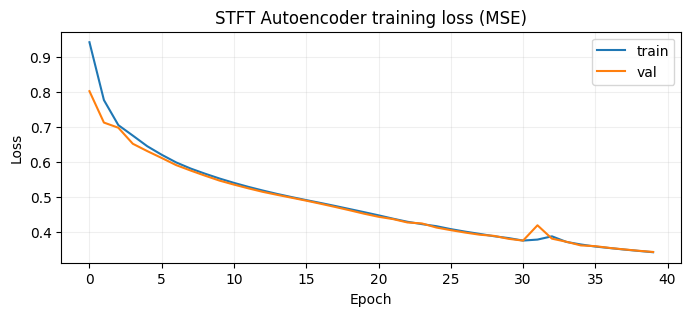

In [15]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
]

hist = ae.fit(
    X_train_n, X_train_n,
    validation_data=(X_val_n, X_val_n),
    epochs=40,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(8, 3))
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.title("STFT Autoencoder training loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


# 9. Score por patch (reconstruction MSE)

In [16]:
def recon_error_mse(x_true: np.ndarray, x_pred: np.ndarray) -> np.ndarray:
    return np.mean((x_true - x_pred) ** 2, axis=(1, 2, 3))

# Normalize all patches using train stats
X_all_n = ((X_patches - mu) / sigma)[..., None]

X_pred = ae.predict(X_all_n, batch_size=512, verbose=0)
patch_scores = recon_error_mse(X_all_n, X_pred)

print("Patch score stats:")
print(f"  mean={patch_scores.mean():.6f}  std={patch_scores.std():.6f}  min={patch_scores.min():.6f}  max={patch_scores.max():.6f}")


Patch score stats:
  mean=0.387541  std=0.584979  min=0.298837  max=9.027637


# 10. Add patch → snapshot (p95 recommended)

In [17]:
meta_scores = meta.copy()
meta_scores["patch_score"] = patch_scores

snap_scores = (
    meta_scores
    .groupby(["run_id", "filepath", "sort_key", "timestamp", "life_fraction"], as_index=False)["patch_score"]
    .quantile(0.95)
    .rename(columns={"patch_score": "snapshot_score"})
    .sort_values(["run_id", "sort_key"])
    .reset_index(drop=True)
)

snap_scores.head()


,run_id,filepath,sort_key,timestamp,life_fraction,snapshot_score
0,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,1066824384000000,2003-10-22 12:06:24,0.000000,0.362374
1,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,1066829653000000,2003-10-22 13:34:13,0.008349,0.354777
2,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,1066835053000000,2003-10-22 15:04:13,0.016698,0.350163
3,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,1066843453000000,2003-10-22 17:24:13,0.025046,0.353653
4,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,1066854253000000,2003-10-22 20:24:13,0.033395,0.367496


# 11. Plot per run (raw + smoothing)

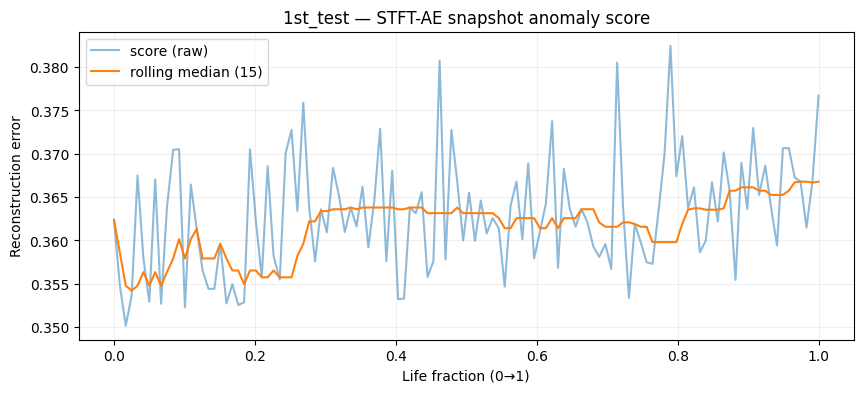

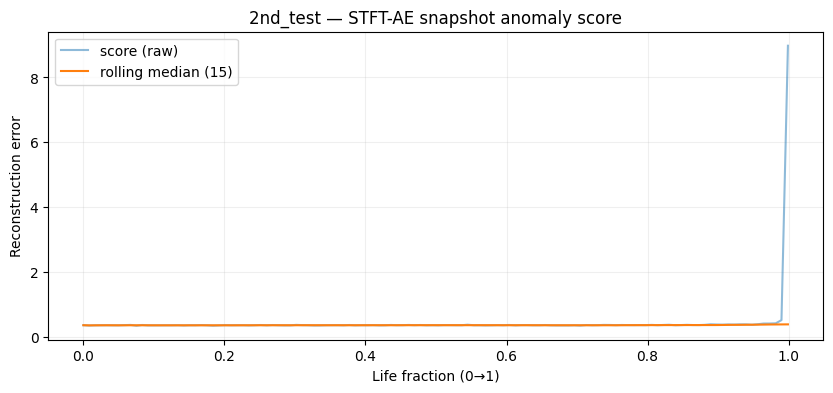

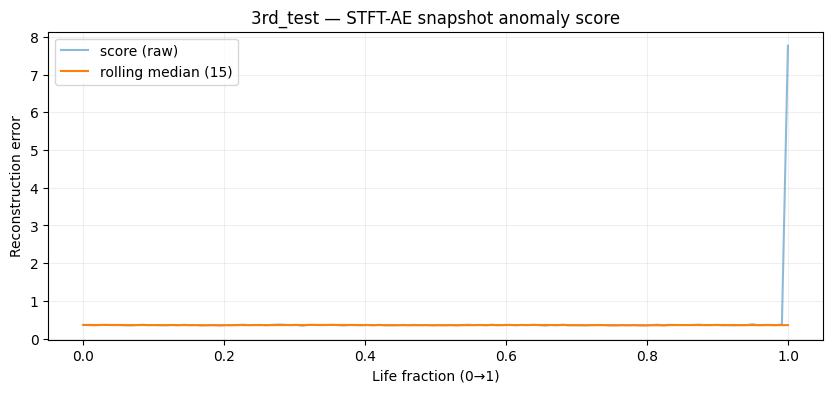

In [18]:
def plot_run_snapshot_scores(snap_scores: pd.DataFrame, run_id: str, smooth_window: int = 15):
    g = snap_scores[snap_scores["run_id"] == run_id].sort_values("sort_key").copy()
    g["score_smooth"] = g["snapshot_score"].rolling(smooth_window, min_periods=1).median()

    plt.figure(figsize=(10, 4))
    plt.plot(g["life_fraction"], g["snapshot_score"], label="score (raw)", alpha=0.5)
    plt.plot(g["life_fraction"], g["score_smooth"], label=f"rolling median ({smooth_window})")
    plt.title(f"{run_id} — STFT-AE snapshot anomaly score")
    plt.xlabel("Life fraction (0→1)")
    plt.ylabel("Reconstruction error")
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

for run in snap_scores["run_id"].unique():
    plot_run_snapshot_scores(snap_scores, run_id=run, smooth_window=cfg.smooth_window)


# 12. Thresholds (p99 / p99.5 based on early-life)

In [19]:
def compute_thresholds_per_run(
    snap_scores: pd.DataFrame,
    healthy_fraction: float,
    percentiles=(0.99, 0.995)
) -> pd.DataFrame:
    rows = []
    for run_id, g in snap_scores.groupby("run_id"):
        g0 = g[g["life_fraction"] <= healthy_fraction]
        if len(g0) < 10:
            continue
        for p in percentiles:
            thr = np.quantile(g0["snapshot_score"].values, p)
            rows.append({"run_id": run_id, "percentile": p, "threshold": thr})
    return pd.DataFrame(rows)

thr_df = compute_thresholds_per_run(
    snap_scores,
    healthy_fraction=cfg.healthy_fraction_per_run,
    percentiles=(0.99, 0.995)
)
thr_df


,run_id,percentile,threshold
0,1st_test,0.990,0.370522
1,1st_test,0.995,0.370525
2,2nd_test,0.990,0.366775
3,2nd_test,0.995,0.367017
4,3rd_test,0.990,0.366951
5,3rd_test,0.995,0.367031


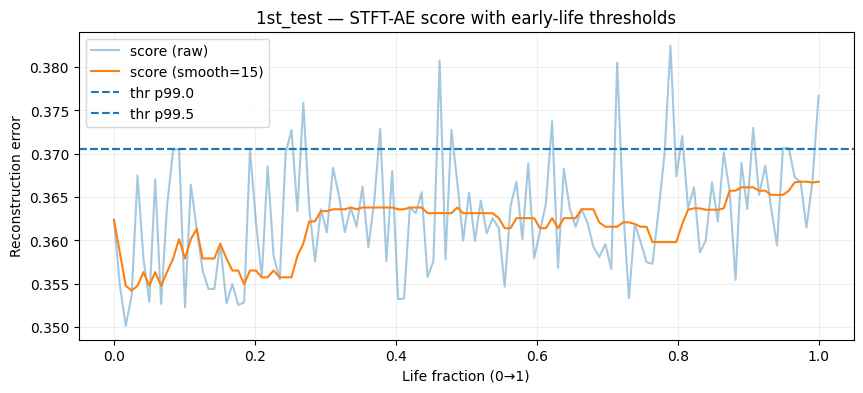

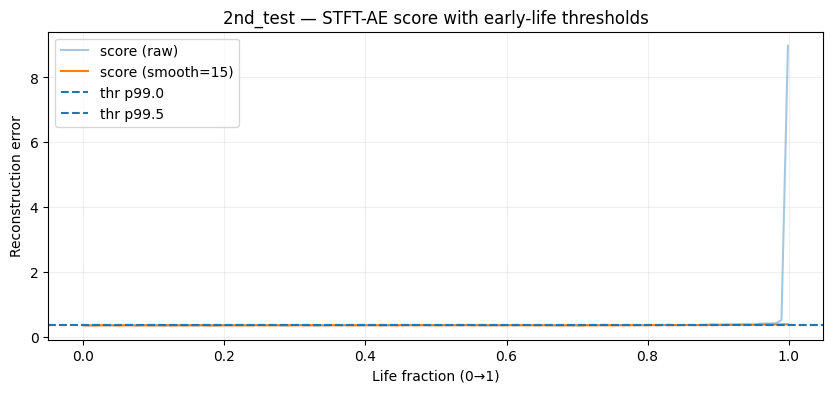

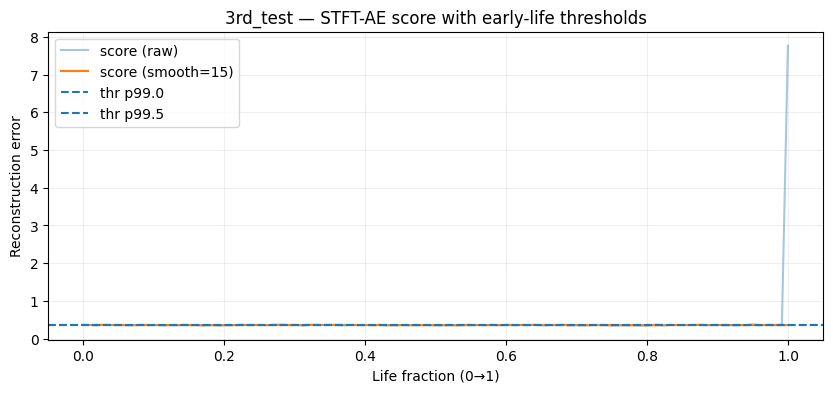

In [20]:
def plot_run_with_thresholds(
    snap_scores: pd.DataFrame,
    thr_df: pd.DataFrame,
    run_id: str,
    smooth_window: int = 15
):
    g = snap_scores[snap_scores["run_id"] == run_id].sort_values("sort_key").copy()
    g["score_smooth"] = g["snapshot_score"].rolling(smooth_window, min_periods=1).median()

    plt.figure(figsize=(10, 4))
    plt.plot(g["life_fraction"], g["snapshot_score"], label="score (raw)", alpha=0.4)
    plt.plot(g["life_fraction"], g["score_smooth"], label=f"score (smooth={smooth_window})")

    t = thr_df[thr_df["run_id"] == run_id]
    for _, r in t.iterrows():
        p_label = f"p{int(r['percentile']*1000)/10:.1f}"
        plt.axhline(r["threshold"], linestyle="--", label=f"thr {p_label}")

    plt.title(f"{run_id} — STFT-AE score with early-life thresholds")
    plt.xlabel("Life fraction (0→1)")
    plt.ylabel("Reconstruction error")
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

for run in snap_scores["run_id"].unique():
    plot_run_with_thresholds(snap_scores, thr_df, run_id=run, smooth_window=cfg.smooth_window)


In [26]:
# ---------------------------------------------------------
# Aggregate patch scores to snapshot scores (p95)
# ---------------------------------------------------------

snap_scores_p95 = (
    meta_scores
    .groupby(
        ["run_id", "filepath", "sort_key", "timestamp", "life_fraction"],
        as_index=False
    )["patch_score"]
    .quantile(0.95)
    .rename(columns={"patch_score": "snapshot_score"})
    .sort_values(["run_id", "sort_key"])
    .reset_index(drop=True)
)

snap_scores_p95.head()


,run_id,filepath,sort_key,timestamp,life_fraction,snapshot_score
0,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,1066824384000000,2003-10-22 12:06:24,0.000000,0.362374
1,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,1066829653000000,2003-10-22 13:34:13,0.008349,0.354777
2,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,1066835053000000,2003-10-22 15:04:13,0.016698,0.350163
3,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,1066843453000000,2003-10-22 17:24:13,0.025046,0.353653
4,1st_test,C:\Users\M4005001\OneDrive - Saint-Gobain\Pess...,1066854253000000,2003-10-22 20:24:13,0.033395,0.367496


In [27]:
print(snap_scores_p95.columns)
print(snap_scores_p95["run_id"].unique())

Index(['run_id', 'filepath', 'sort_key', 'timestamp', 'life_fraction',
       'snapshot_score'],
      dtype='str')
<StringArray>
['1st_test', '2nd_test', '3rd_test']
Length: 3, dtype: str


In [32]:
def plot_run_snapshot_scores(
    snap_scores: pd.DataFrame,
    run_id: str,
    smooth_window: int = 15,
    ylim: tuple[float, float] | None = None,
    title_suffix: str = ""
):
    g = snap_scores[snap_scores["run_id"] == run_id].sort_values("sort_key").copy()
    g["score_smooth"] = g["snapshot_score"].rolling(smooth_window, min_periods=1).median()

    plt.figure(figsize=(10, 4))
    plt.plot(g["life_fraction"], g["snapshot_score"], label="score (raw)", alpha=0.5)
    plt.plot(g["life_fraction"], g["score_smooth"], label=f"rolling median ({smooth_window})")
    plt.title(f"{run_id} — anomaly score {title_suffix}")
    plt.xlabel("Life fraction (0→1)")
    plt.ylabel("Reconstruction error")
    plt.grid(True, alpha=0.2)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.legend()
    plt.show()


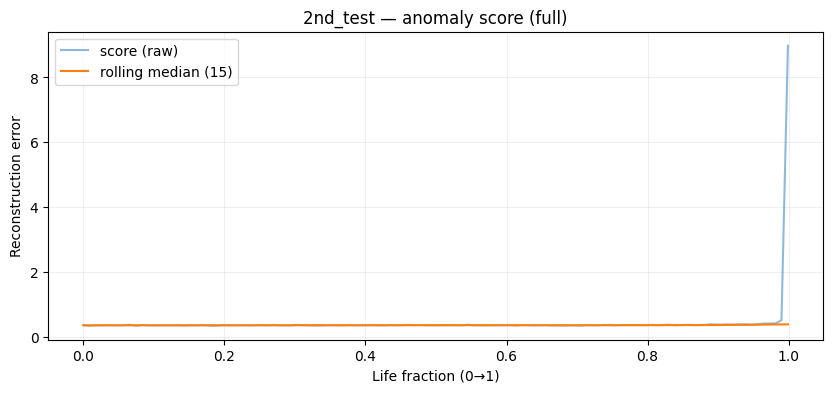

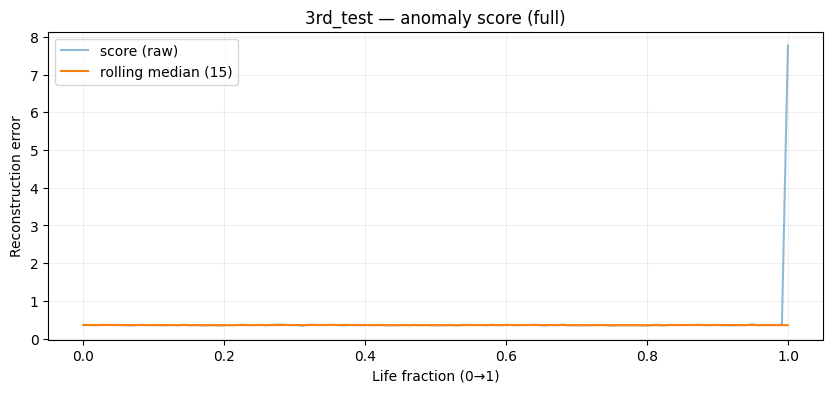

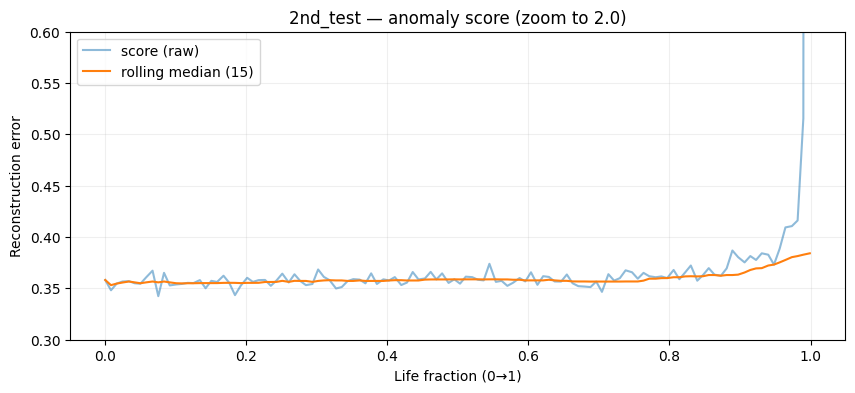

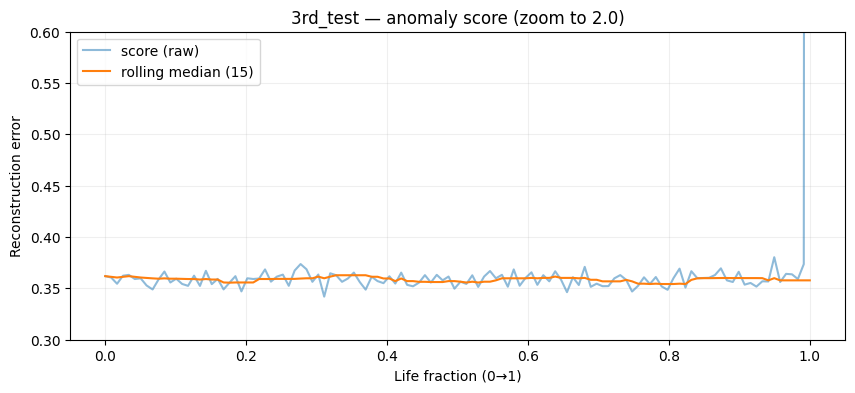

In [36]:
# 2nd/3rd: full scale
plot_run_snapshot_scores(snap_scores_p95, "2nd_test", ylim=None, title_suffix="(full)")
plot_run_snapshot_scores(snap_scores_p95, "3rd_test", ylim=None, title_suffix="(full)")

# 2nd/3rd: zoom
plot_run_snapshot_scores(snap_scores_p95, "2nd_test", ylim=(0.3, 0.6), title_suffix="(zoom to 2.0)")
plot_run_snapshot_scores(snap_scores_p95, "3rd_test", ylim=(0.3, 0.6), title_suffix="(zoom to 2.0)")
